# Analyse du commerce électronique brésilien

## Importations des librairies

In [1]:
import pandas as pd, numpy as np, os, warnings, seaborn as sns
from datetime import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
font1 = fm.FontProperties(size=20)
font2 = fm.FontProperties(size=24)


if int(str(sns.__version__).split('.')[1]) > 8 : 
    plt.style.use('seaborn-v0_8-darkgrid')
else:
    plt.style.use('seaborn-darkgrid')
    
sns.set(font_scale=2)
warnings.filterwarnings(action="ignore")

os.chdir("C:/Users/etien/Documents/CCI/_HUB/cours/2024-2025/big_data/_git/Python_pandas/donnees")

## Importations des doonées 

In [2]:
achat = pd.read_parquet('ecommerce/analyse_achat.parquet', engine='pyarrow')
customers = pd.read_parquet('ecommerce/customers.parquet', engine='pyarrow')
produits = pd.read_parquet('ecommerce/products.parquet', engine='pyarrow')
ventes = pd.read_parquet('ecommerce/analyse_ventes.parquet', engine='pyarrow')
achat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 51 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   order_id            112650 non-null  object        
 1   order_item_id       112650 non-null  int64         
 2   product_id          112650 non-null  object        
 3   seller_id           112650 non-null  object        
 4   price               112650 non-null  float64       
 5   freight_value       112650 non-null  float64       
 6   shipping_limit      112650 non-null  datetime64[us]
 7   limit               112650 non-null  float64       
 8   name_lenght         111047 non-null  float64       
 9   description_lenght  111047 non-null  float64       
 10  photos_qty          111047 non-null  float64       
 11  weight_g            112632 non-null  float64       
 12  length_cm           112632 non-null  float64       
 13  height_cm           112632 no

In [3]:
achat.sample(5)

order_id  order_item_id  \
37841   55d599a99424bf5a0293a84f8f65a13f              1   
51265   748d3b50f6f4b32e9998bb62826d4812              1   
77220   afcda0566edd7333aa8184a5985a47ba              1   
110179  fa5a411aff02eb7f724264bb98ff585d              1   
7148    1031ac71b203bb98af456f6abf3c8862              1   

                              product_id                         seller_id  \
37841   e799a2b8707a6a256fa3c040b75d2713  77530e9772f57a62c906e1c21538ab82   
51265   394b16cd32e9f883365dd7ebac4edbe0  8b321bb669392f5163d04c59e235e066   
77220   679d1a26cc192f14e7e30ae397f8b089  2a5b78b41cd05baeac8df54c6606b92c   
110179  00ba6d766f0b1d7b78a5ce3e1e033263  53e4c6e0f4312d4d2107a8c9cddf45cd   
7148    e307200b995cf8d99d85db7d09e4ba00  6a8b085f816a1f75f92dbac6eb545f8f   

         price  freight_value      shipping_limit      limit  name_lenght  \
37841   129.00          20.14 2017-11-23 16:30:31   0.160833         60.0   
51265    14.40          15.79 2018-01-24 22:50:10   0.245833         53.0   
77220   879.77          24.04 2018-06-10 21:52:42   0.196667         27.0   
110179   47.99          20.32 2017-06-19 11:42:51   1.997500         52.0   
7148     16.90          15.10 2018-02-19 14:47:52  23.259167         59.0   

        description_lenght  ...  cust_state     cust_name_state   cust_lat  \
37841               2260.0  ...          MS  Mato Grosso do Sul -20.550506   
51265                377.0  ...          BA               Bahia -12.893005   
77220               1310.0  ...          RJ      Rio de Janeiro -22.954409   
110179               418.0  ...          SP           São Paulo -20.514002   
7148                 295.0  ...          MS  Mato Grosso do Sul -20.503974   

         cust_lng  sell_zip_code  sell_city sell_state sell_name_state  \
37841  -56.678357          80310   curitiba         PR          Paraná   
51265  -38.756718           1212  sao paulo         SP       São Paulo   
77220  -43.185650          35570    formiga         MG    Minas Gerais   
110179 -50.352756          13920   pedreira         SP       São Paulo   
7148   -54.631454          14709  bebedouro         SP       São Paulo   

         sell_lat   sell_lng  
37841  -25.456934 -49.309455  
51265  -23.538269 -46.639423  
77220  -20.462536 -45.433059  
110179 -22.740325 -46.896754  
7148   -20.924600 -48.490591  

[5 rows x 51 columns]

### Récupération des scores

In [4]:
achat = achat.merge(ventes[['order_id','score', 'score_1', 'score_2', 'score_3', 'score_4', 'score_5']], 
                                         on='order_id')

### Préparation des données
#### Nettoyage des valeurs extrem

In [5]:
achat = achat[(achat['weight_g'] > 0) & (achat['weight_g'] < achat['weight_g'].quantile(0.99))]
achat = achat[(achat['livree'] > 0) & (achat['livree'] < achat['livree'].quantile(0.99))]

#### anonymisation des vendeurs 

In [6]:
def anonymiser_vendeurs(df, id_col="seller_id"):
    """
    Remplace les ID des vendeurs par des noms anonymisés (vendeur_1, vendeur_2, ...).

    :param df: DataFrame contenant les identifiants des vendeurs
    :param id_col: Nom de la colonne contenant les IDs des vendeurs
    :return: DataFrame avec une nouvelle colonne "vendeur_anonyme"
    """
    unique_vendeurs = df[id_col].unique()
    mapping_vendeurs = {vendeur: f"vendeur_{i+1}" for i, vendeur in enumerate(unique_vendeurs)}

    df["seller_id_anon"] = df[id_col].map(mapping_vendeurs)

    return df

achat = anonymiser_vendeurs(achat)

#### Définition des périodes de solde

In [7]:
def periode_soldes(date):
    if date.month in [1, 7] or (date.month == 11 and date.day >= 20 and date.day <= 30):
        return 1
    return 0

achat["periode_soldes"] = achat["purchase_timestamp"].apply(periode_soldes)

### Concaténation de vente et moyen de payement

 ### 1 / Analyse de la Tarification et des Frais de Livraison (Optimisation du pricing pour améliorer la rentabilité)

#### Préparation des données 

In [8]:
achat_livraison = achat.copy()

achat_livraison["marge_brute"] = achat_livraison["price"] - achat_livraison["freight_value"]

# https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude

def haversine(lat1, lon1, lat2, lon2):

    R = 6371  
    
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    # Appliquer la formule de Haversine
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    return R * c  

achat_livraison["distance_km"] = achat_livraison.apply(
    lambda row: haversine(row["cust_lat"], row["cust_lng"], row["sell_lat"], row["sell_lng"]) 
    if pd.notnull(row["cust_lat"]) and pd.notnull(row["cust_lng"]) and pd.notnull(row["sell_lat"]) and pd.notnull(row["sell_lng"]) 
    else np.nan, 
    axis=1
)

achat_livraison["total_spent_par_client"] = achat_livraison.groupby("customer_unique_id")["price"].transform("sum")

achat_livraison["nb_commandes_par_vendeur"] = achat_livraison.groupby("seller_id_anon")["order_id"].transform("count")

achat_livraison["prix_moyen_categorie"] = achat_livraison.groupby("category_name")["price"].transform("mean")
achat_livraison["freight_moyen_categorie"] = achat_livraison.groupby("category_name")["freight_value"].transform("mean")

achat_livraison["freight_moyen_region"] = achat_livraison.groupby("cust_state")["freight_value"].transform("mean")

achat_livraison["freight_par_distance"] = achat_livraison["freight_value"] / achat_livraison["distance_km"]
achat_livraison["freight_par_distance"].replace([np.inf, -np.inf], np.nan, inplace=True)  # Remplacer les infinis par NaN

achat_livraison["purchase_timestamp"] = pd.to_datetime(achat_livraison["purchase_timestamp"])

achat_livraison = achat_livraison[(achat_livraison["price"] > 1) & (achat_livraison["price"] < achat_livraison["price"].quantile(0.99))]  # Supprimer les prix extrêmes (top 1%)
achat_livraison = achat_livraison[(achat_livraison["freight_value"] > 0) & (achat_livraison["freight_value"] < achat_livraison["freight_value"].quantile(0.99))]  # Supprimer outliers frais de livraison
achat_livraison.info()

<class 'pandas.core.frame.DataFrame'>
Index: 105444 entries, 0 to 112649
Data columns (total 67 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   order_id                  105444 non-null  object        
 1   order_item_id             105444 non-null  int64         
 2   product_id                105444 non-null  object        
 3   seller_id                 105444 non-null  object        
 4   price                     105444 non-null  float64       
 5   freight_value             105444 non-null  float64       
 6   shipping_limit            105444 non-null  datetime64[us]
 7   limit                     105444 non-null  float64       
 8   name_lenght               103985 non-null  float64       
 9   description_lenght        103985 non-null  float64       
 10  photos_qty                103985 non-null  float64       
 11  weight_g                  105444 non-null  float64       
 12  length_

#### 1 - Quel tranche de produits par prix est le plus vendu 

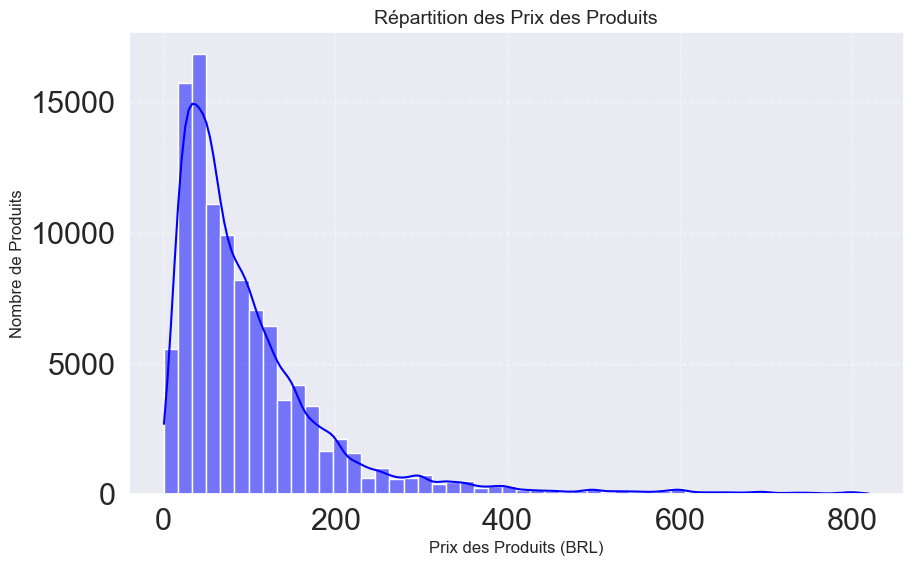

In [9]:
plt.figure(figsize=(10, 6))
sns.histplot(achat_livraison["price"], bins=50, kde=True, color="blue")  # Histogramme avec courbe de densité

plt.title("Répartition des Prix des Produits", fontsize=14)
plt.xlabel("Prix des Produits (BRL)", fontsize=12)
plt.ylabel("Nombre de Produits", fontsize=12)

plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

#### 2 - Quel frais de livraison est plus appliqué

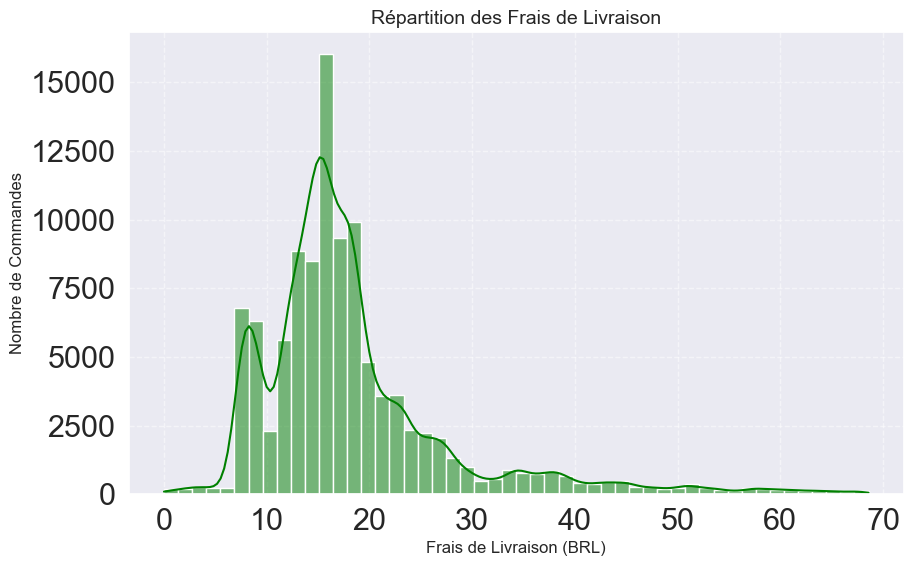

In [10]:
plt.figure(figsize=(10, 6))
sns.histplot(achat_livraison["freight_value"], bins=50, kde=True, color="green")  # Histogramme avec courbe de densité

plt.title("Répartition des Frais de Livraison", fontsize=14)
plt.xlabel("Frais de Livraison (BRL)", fontsize=12)
plt.ylabel("Nombre de Commandes", fontsize=12)

plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

#### 3 - Le prix du produits est il corrélé à ses frais de livraison ?

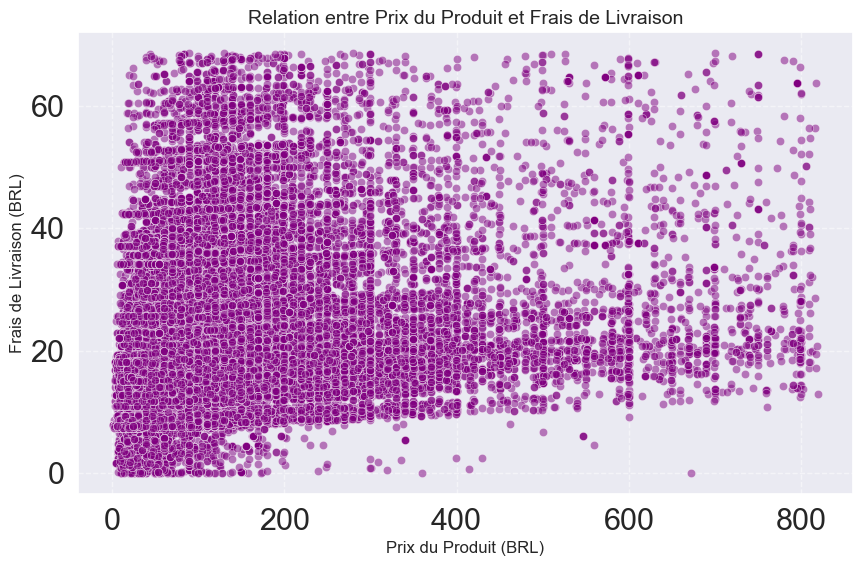

In [11]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=achat_livraison["price"], y=achat_livraison["freight_value"], alpha=0.5, color="purple")

plt.title("Relation entre Prix du Produit et Frais de Livraison", fontsize=14)
plt.xlabel("Prix du Produit (BRL)", fontsize=12)
plt.ylabel("Frais de Livraison (BRL)", fontsize=12)

plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

#### 4 - Evolution des prix et des frais de livraison dans le temps

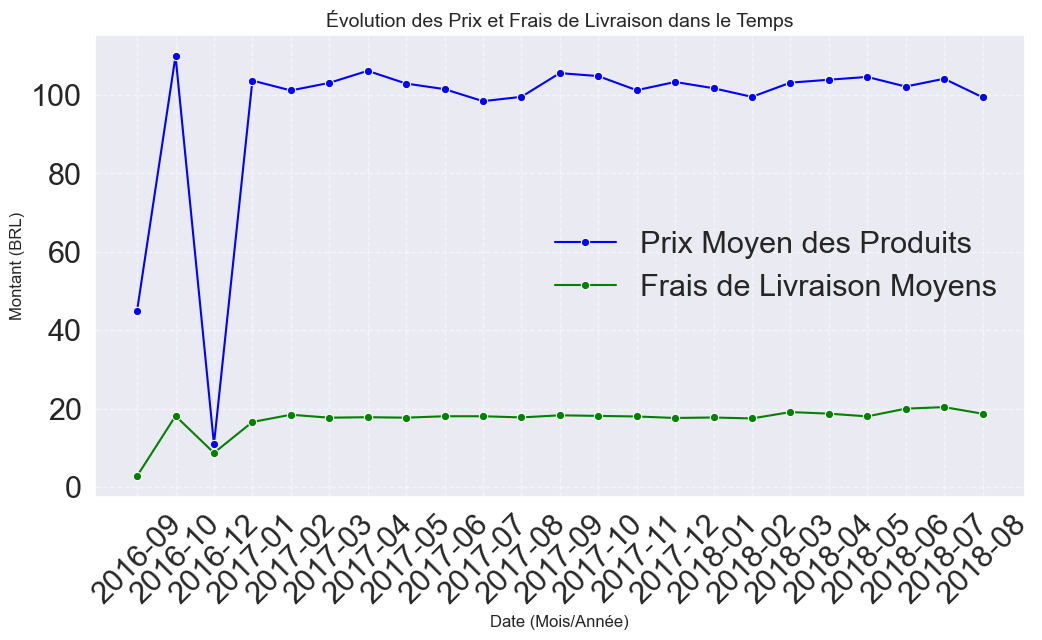

In [12]:
df_time = achat_livraison.groupby(achat_livraison["purchase_timestamp"].dt.to_period("M")).agg({
    "price": "mean",
    "freight_value": "mean"
}).reset_index()

df_time["purchase_timestamp"] = df_time["purchase_timestamp"].astype(str)

plt.figure(figsize=(12, 6))
sns.lineplot(x=df_time["purchase_timestamp"], y=df_time["price"], label="Prix Moyen des Produits", marker="o", color="blue")
sns.lineplot(x=df_time["purchase_timestamp"], y=df_time["freight_value"], label="Frais de Livraison Moyens", marker="o", color="green")

plt.title("Évolution des Prix et Frais de Livraison dans le Temps", fontsize=14)
plt.xlabel("Date (Mois/Année)", fontsize=12)
plt.ylabel("Montant (BRL)", fontsize=12)
plt.xticks(rotation=45)  
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)

#### 5 - Es ce qu'il y a une corrélation entre distance client vendeur et frais de livraison ?

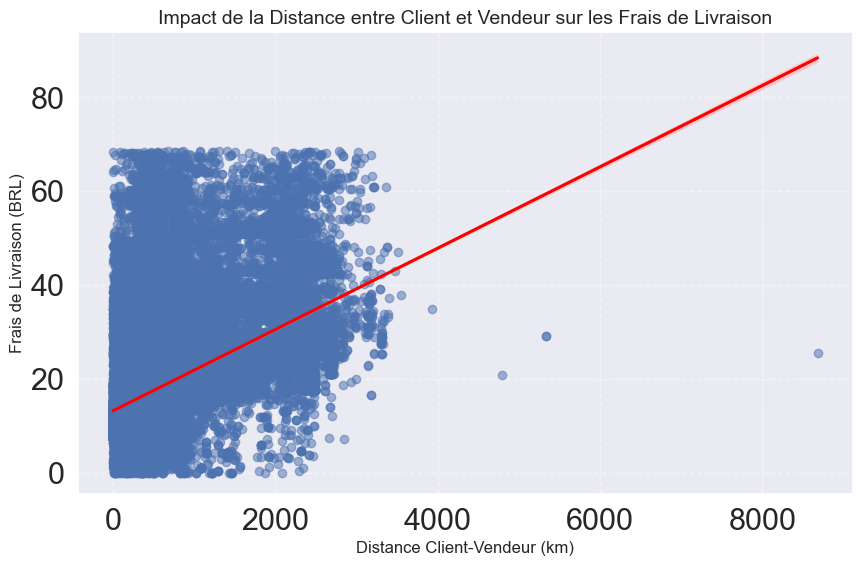

In [13]:
plt.figure(figsize=(10, 6))
sns.regplot(x=achat_livraison["distance_km"], y=achat_livraison["freight_value"], scatter_kws={"alpha":0.5}, line_kws={"color":"red"})


plt.title("Impact de la Distance entre Client et Vendeur sur les Frais de Livraison", fontsize=14)
plt.xlabel("Distance Client-Vendeur (km)", fontsize=12)
plt.ylabel("Frais de Livraison (BRL)", fontsize=12)


plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

#### 6 - Les frais de livraison dépendent-ils de la région du vendeur ? 

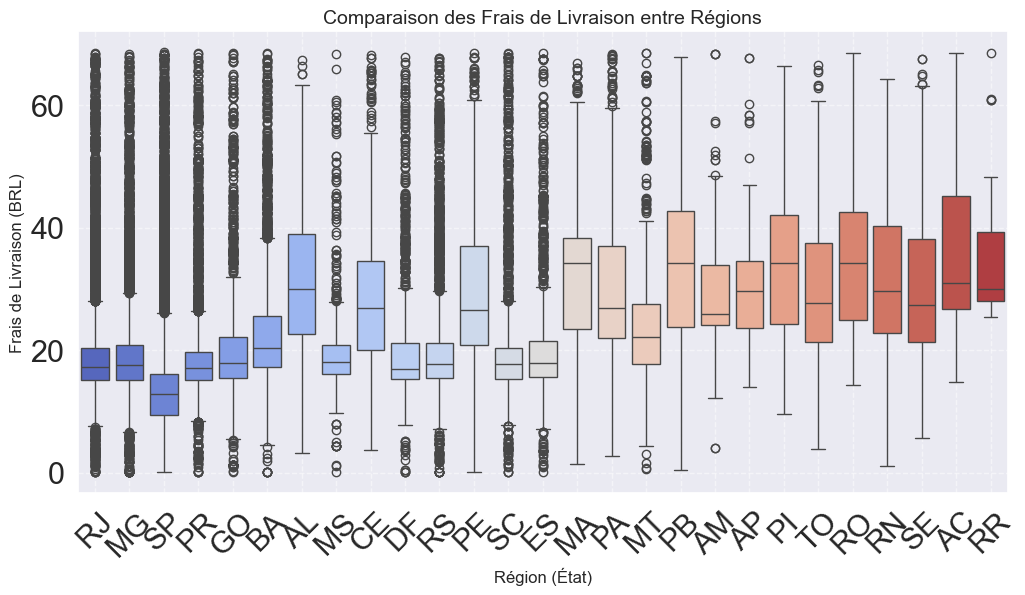

In [14]:
plt.figure(figsize=(12, 6))
sns.boxplot(x=achat_livraison["cust_state"], y=achat_livraison["freight_value"], palette="coolwarm")


plt.title("Comparaison des Frais de Livraison entre Régions", fontsize=14)
plt.xlabel("Région (État)", fontsize=12)
plt.ylabel("Frais de Livraison (BRL)", fontsize=12)

plt.xticks(rotation=45)

plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

#### 7 - calcule des produits les plus rentables

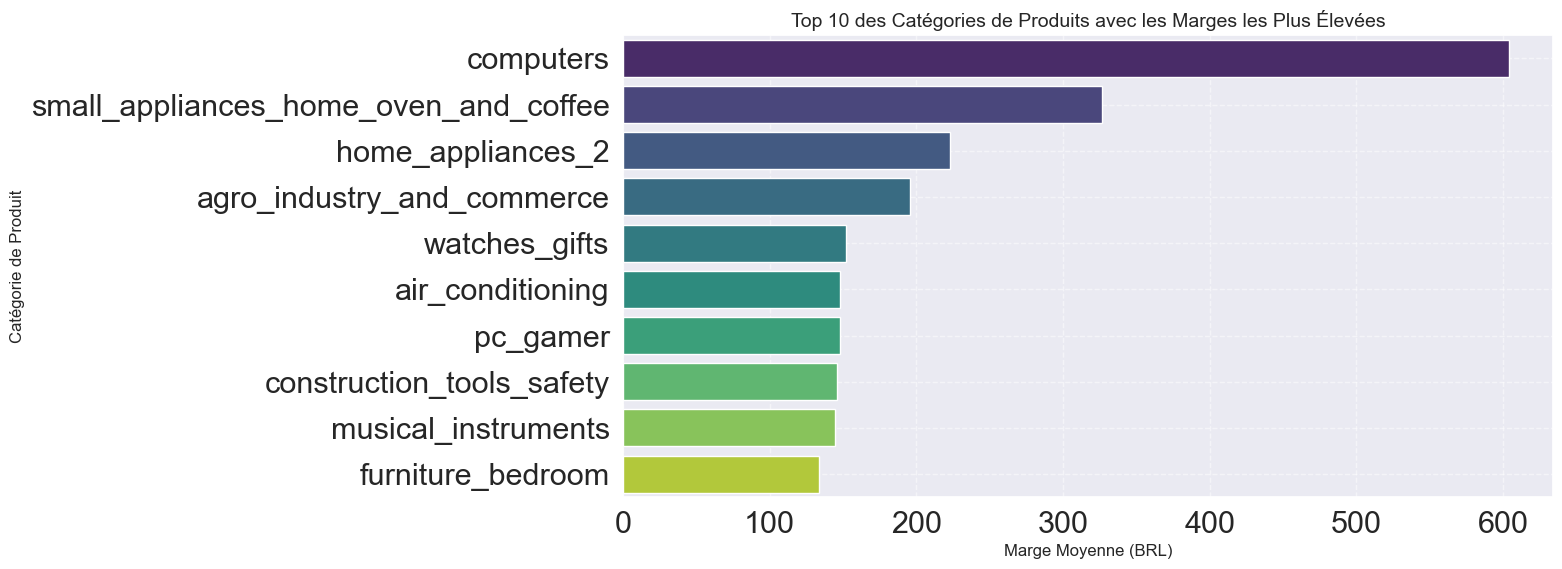

In [15]:
df_marge_categorie = achat_livraison.groupby("category_name")["marge_brute"].mean().reset_index()

df_marge_categorie = df_marge_categorie.sort_values(by="marge_brute", ascending=False).head(10)  # Top 10

plt.figure(figsize=(12, 6))
sns.barplot(x="marge_brute", y="category_name", data=df_marge_categorie, palette="viridis")

plt.title("Top 10 des Catégories de Produits avec les Marges les Plus Élevées", fontsize=14)
plt.xlabel("Marge Moyenne (BRL)", fontsize=12)
plt.ylabel("Catégorie de Produit", fontsize=12)

plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

#### 8 - Es ce que les différents vendeur appliquer des frais de livraison différents ? 

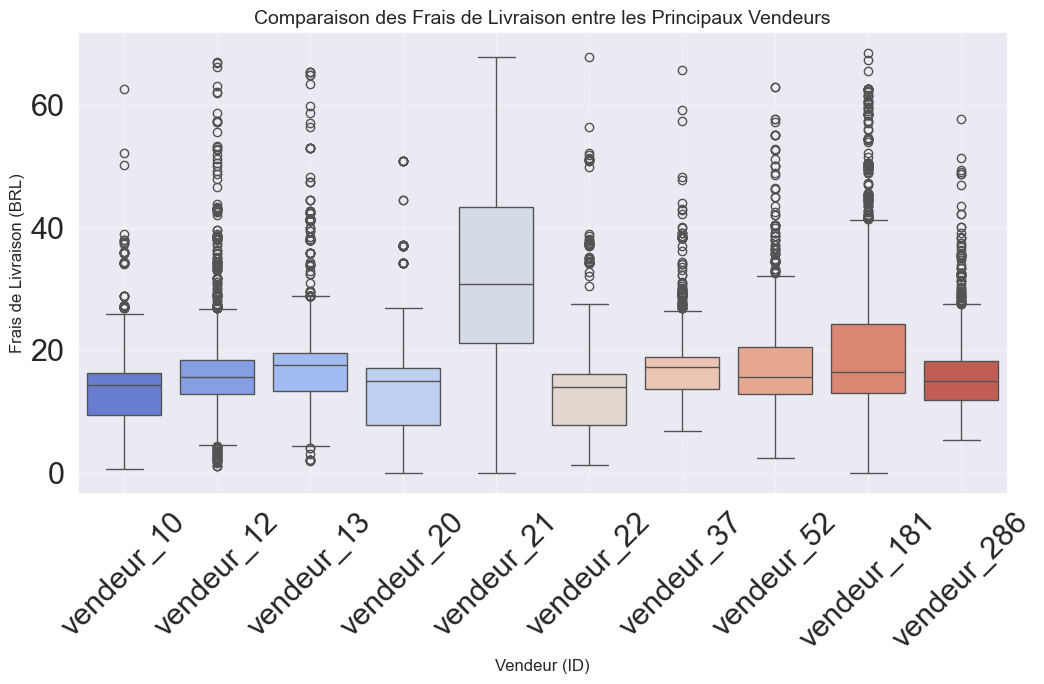

In [16]:
top_vendeurs = achat_livraison["seller_id_anon"].value_counts().index[:10]  # Top 10 vendeurs en nombre de ventes

df_top_vendeurs = achat_livraison[achat_livraison["seller_id_anon"].isin(top_vendeurs)]

plt.figure(figsize=(12, 6))
sns.boxplot(x="seller_id_anon", y="freight_value", data=df_top_vendeurs, palette="coolwarm")

plt.title("Comparaison des Frais de Livraison entre les Principaux Vendeurs", fontsize=14)
plt.xlabel("Vendeur (ID)", fontsize=12)
plt.ylabel("Frais de Livraison (BRL)", fontsize=12)

plt.xticks(rotation=45)

plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

#### 9 - Es ce que les vendeur applique des prix différents sur un même produit ? 

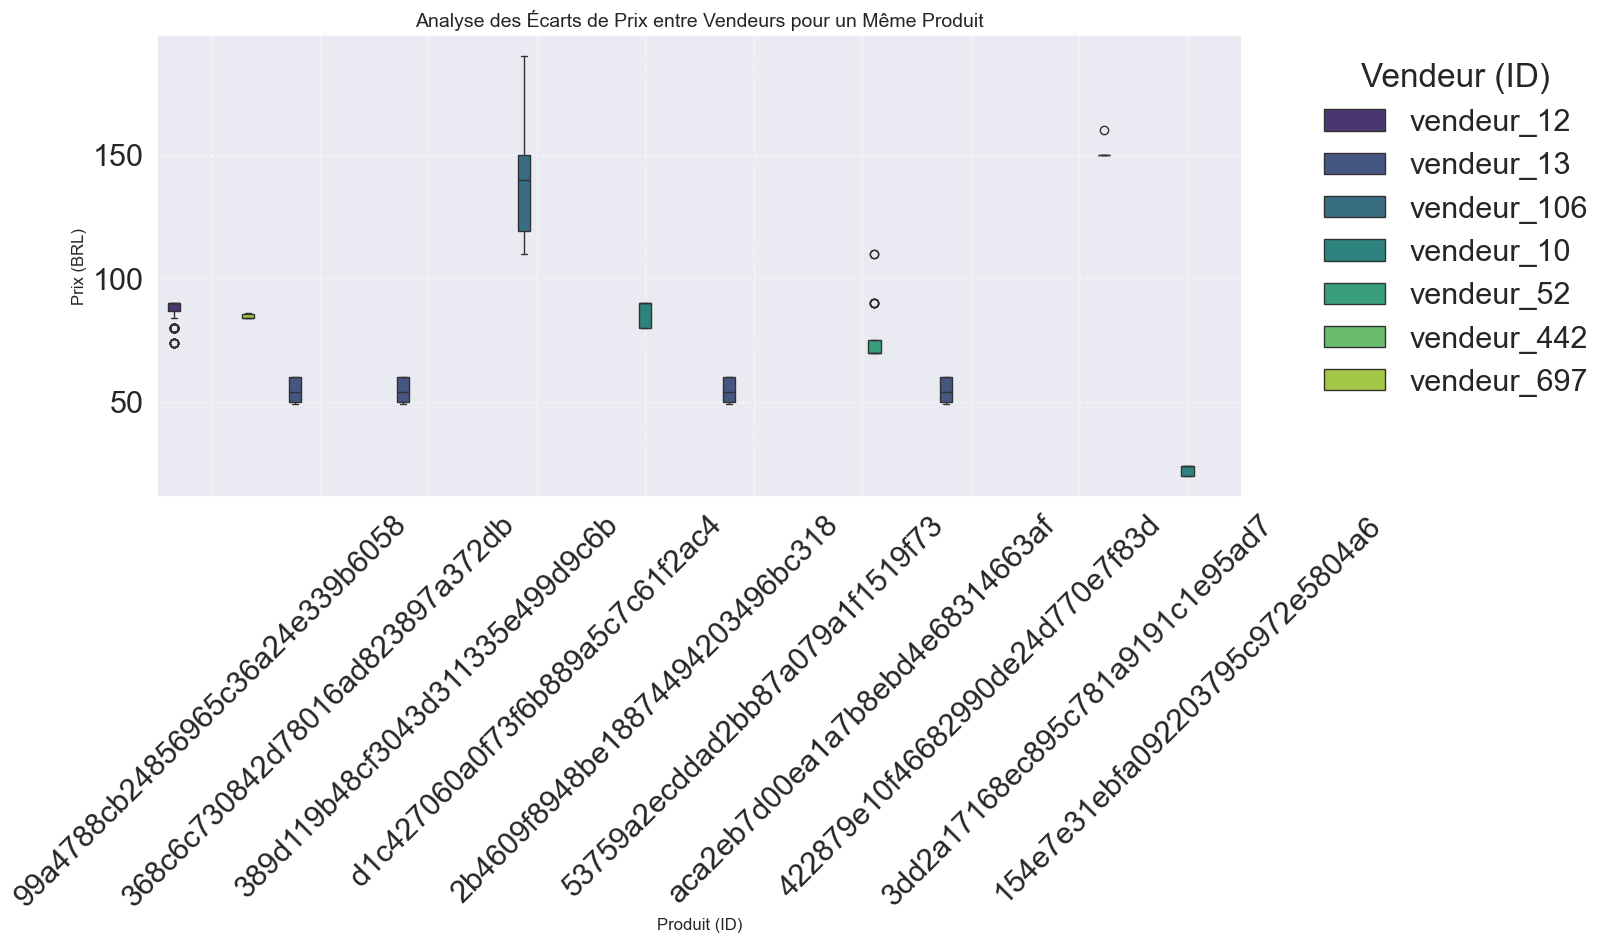

In [17]:
top_produits = achat_livraison["product_id"].value_counts().index[:10]  # Top 10 produits les plus vendus

df_top_produits = achat_livraison[achat_livraison["product_id"].isin(top_produits)]

plt.figure(figsize=(14, 6))
sns.boxplot(x="product_id", y="price", hue="seller_id_anon", data=df_top_produits, palette="viridis")

plt.title("Analyse des Écarts de Prix entre Vendeurs pour un Même Produit", fontsize=14)
plt.xlabel("Produit (ID)", fontsize=12)
plt.ylabel("Prix (BRL)", fontsize=12)

plt.xticks(rotation=45)

plt.legend(title="Vendeur (ID)", bbox_to_anchor=(1.05, 1), loc='upper left')  # Légende des vendeurs
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

#### 10 - Impact du mode de transport sur les frais de livraison

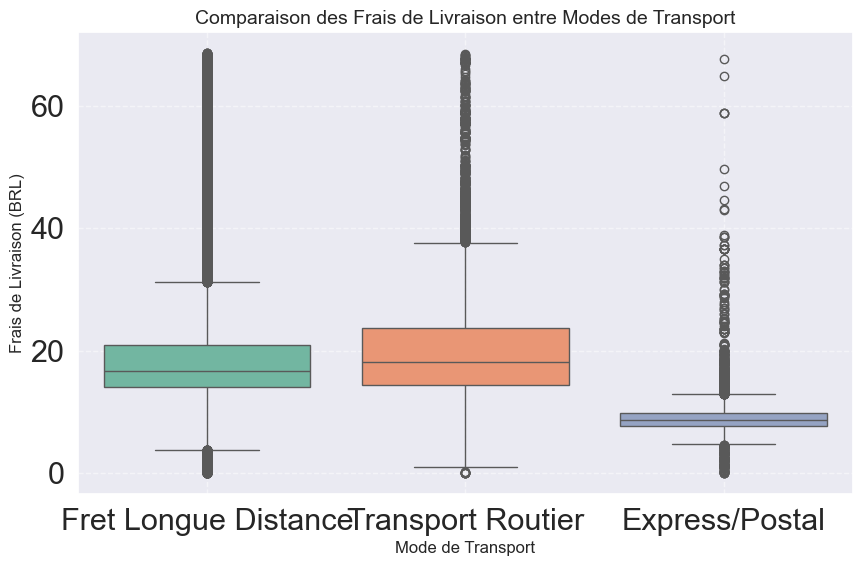

In [18]:
def definir_mode_transport(row):
    if row["weight_g"] <= 2000 and row["distance_km"] <= 50:
        return "Express/Postal"
    elif 2000 < row["weight_g"] <= 10000 and row["distance_km"] <= 500:
        return "Transport Routier"
    else:
        return "Fret Longue Distance"

achat_livraison["mode_transport"] = achat_livraison.apply(definir_mode_transport, axis=1)

plt.figure(figsize=(10, 6))
sns.boxplot(x="mode_transport", y="freight_value", data=achat_livraison, palette="Set2")

plt.title("Comparaison des Frais de Livraison entre Modes de Transport", fontsize=14)
plt.xlabel("Mode de Transport", fontsize=12)
plt.ylabel("Frais de Livraison (BRL)", fontsize=12)

plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

### 2 - Analyse des Différences entre Petits et Grands Vendeurs (Qui vend le mieux ?)

#### Préparation des données 

In [19]:
achat_vendeur = achat.copy()

achat_vendeur["nb_commandes_par_vendeur"] = achat_vendeur.groupby("seller_id_anon")["order_id"].transform("count")

achat_vendeur["revenu_total_vendeur"] = achat_vendeur.groupby("seller_id_anon")["price"].transform("sum")

achat_vendeur["categorie_dominante_vendeur"] = achat_vendeur.groupby("seller_id_anon")["category_name"].transform(lambda x: x.mode()[0] if not x.mode().empty else None)

seuil_grand_vendeur = achat_vendeur["nb_commandes_par_vendeur"].median()
achat_vendeur["taille_vendeur"] = achat_vendeur["nb_commandes_par_vendeur"].apply(lambda x: "Grand" if x >= seuil_grand_vendeur else "Petit")

achat_vendeur["prix_moyen_vendeur"] = achat_vendeur.groupby("seller_id_anon")["price"].transform("mean")

achat_vendeur["annee_mois"] = achat_vendeur["purchase_timestamp"].dt.to_period("M")
achat_vendeur["evolution_part_marche"] = achat_vendeur.groupby(["seller_id_anon", "annee_mois"])["order_id"].transform("count")

achat_vendeur["taux_fidelisation_vendeur"] = achat_vendeur.groupby("seller_id_anon")["customer_unique_id"].transform(lambda x: x.duplicated().sum() / len(x))
achat_vendeur.info()

<class 'pandas.core.frame.DataFrame'>
Index: 107975 entries, 0 to 112649
Data columns (total 66 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   order_id                     107975 non-null  object        
 1   order_item_id                107975 non-null  int64         
 2   product_id                   107975 non-null  object        
 3   seller_id                    107975 non-null  object        
 4   price                        107975 non-null  float64       
 5   freight_value                107975 non-null  float64       
 6   shipping_limit               107975 non-null  datetime64[us]
 7   limit                        107975 non-null  float64       
 8   name_lenght                  106489 non-null  float64       
 9   description_lenght           106489 non-null  float64       
 10  photos_qty                   106489 non-null  float64       
 11  weight_g                     10

#### 1 - Répartition des plus gros vendeur de la plateforme

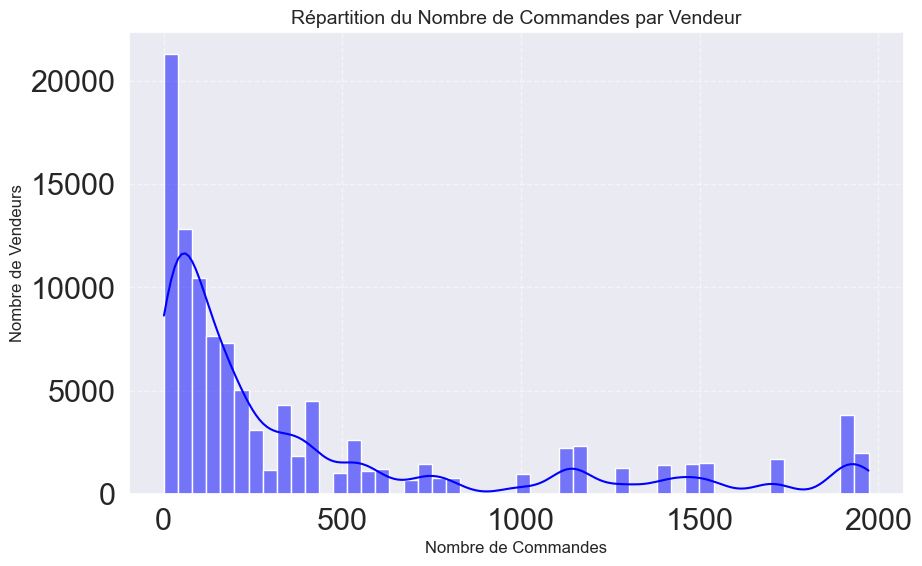

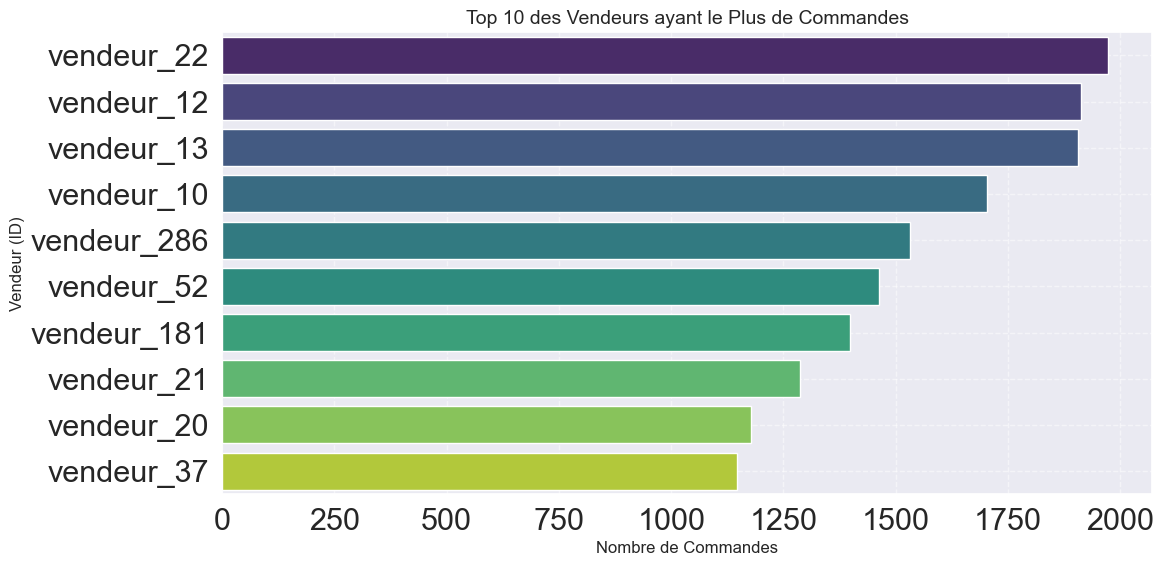

In [20]:
plt.figure(figsize=(10, 6))
sns.histplot(achat_vendeur["nb_commandes_par_vendeur"], bins=50, kde=True, color="blue")

plt.title("Répartition du Nombre de Commandes par Vendeur", fontsize=14)
plt.xlabel("Nombre de Commandes", fontsize=12)
plt.ylabel("Nombre de Vendeurs", fontsize=12)

plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

top_vendeurs = achat_vendeur.groupby("seller_id_anon")["nb_commandes_par_vendeur"].max().nlargest(10).reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x="nb_commandes_par_vendeur", y="seller_id_anon", data=top_vendeurs, palette="viridis")

plt.title("Top 10 des Vendeurs ayant le Plus de Commandes", fontsize=14)
plt.xlabel("Nombre de Commandes", fontsize=12)
plt.ylabel("Vendeur (ID)", fontsize=12)

plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

#### 2 - Répartition des plus gros chiffre d'affaire de la plateforme

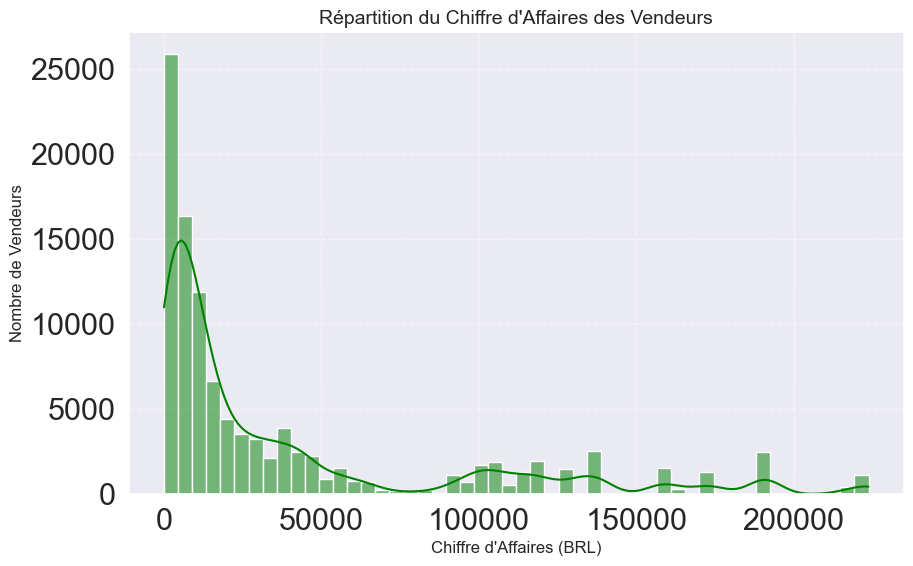

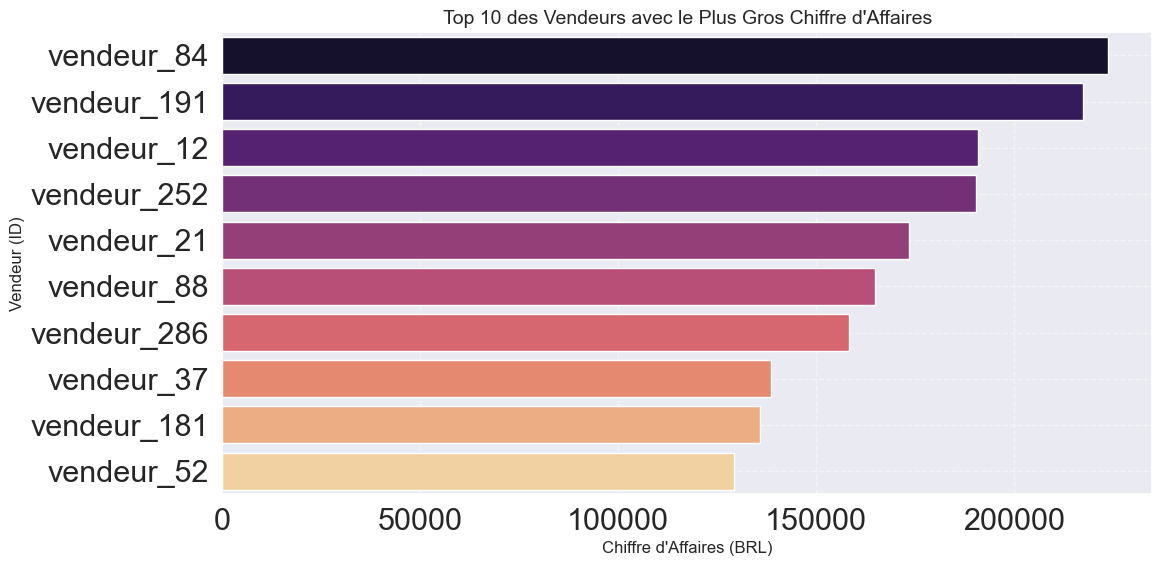

In [21]:

plt.figure(figsize=(10, 6))
sns.histplot(achat_vendeur["revenu_total_vendeur"], bins=50, kde=True, color="green")

plt.title("Répartition du Chiffre d'Affaires des Vendeurs", fontsize=14)
plt.xlabel("Chiffre d'Affaires (BRL)", fontsize=12)
plt.ylabel("Nombre de Vendeurs", fontsize=12)

plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

top_vendeurs_ca = achat_vendeur.groupby("seller_id_anon")["revenu_total_vendeur"].max().nlargest(10).reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x="revenu_total_vendeur", y="seller_id_anon", data=top_vendeurs_ca, palette="magma")

plt.title("Top 10 des Vendeurs avec le Plus Gros Chiffre d'Affaires", fontsize=14)
plt.xlabel("Chiffre d'Affaires (BRL)", fontsize=12)
plt.ylabel("Vendeur (ID)", fontsize=12)

plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

#### 3 - Les catégorie privilégié chez les gros vendeur

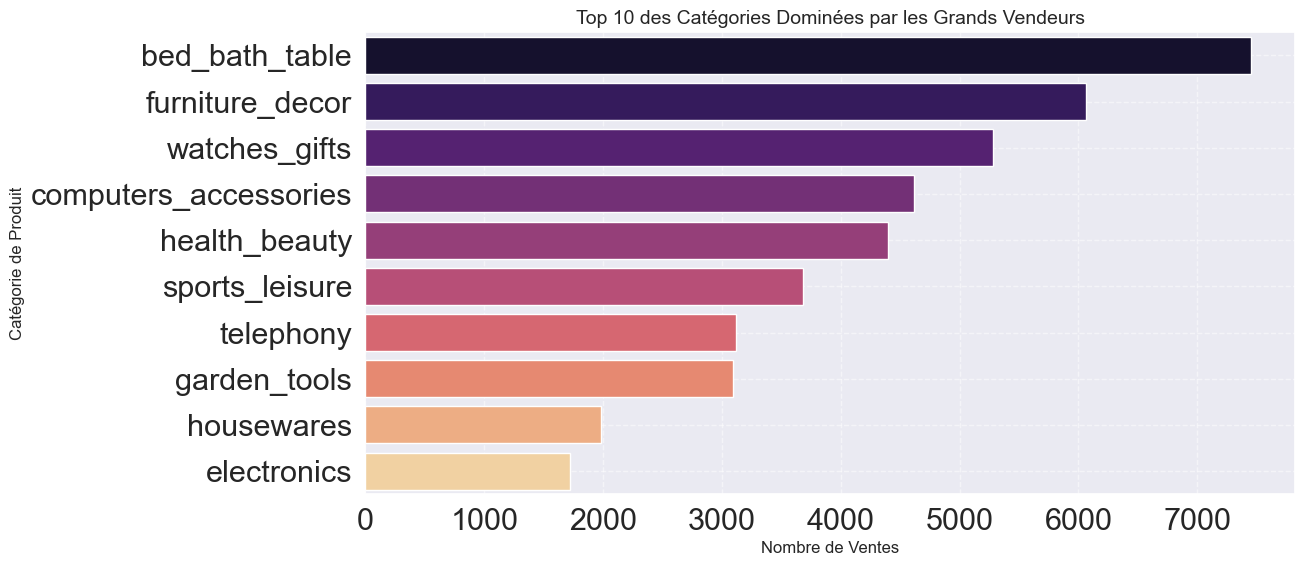

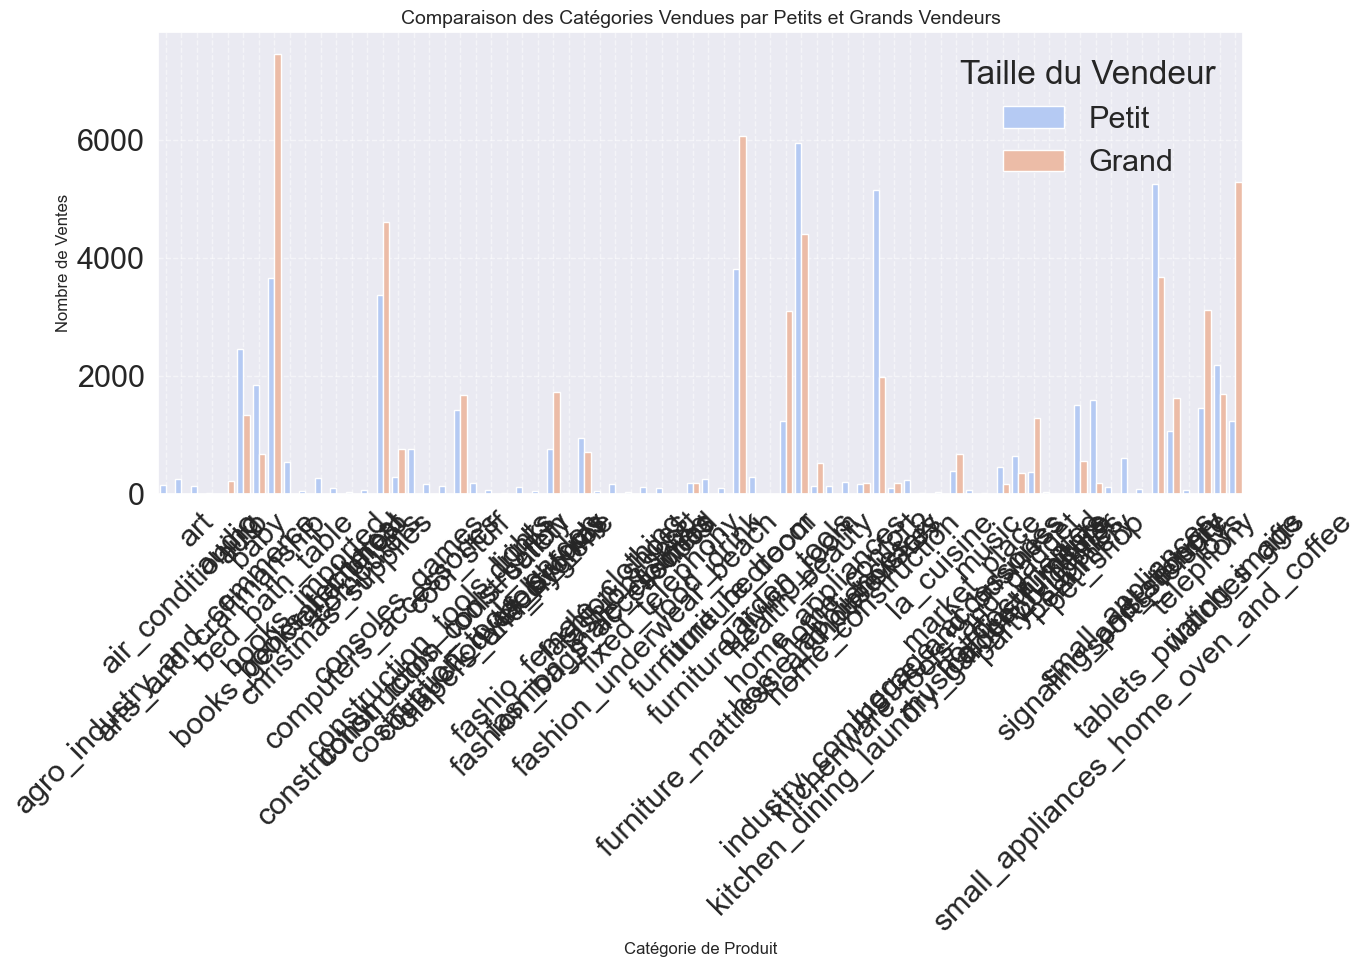

In [22]:
df_grands_vendeurs = achat_vendeur[achat_vendeur["taille_vendeur"] == "Grand"]

top_categories_grands = df_grands_vendeurs["categorie_dominante_vendeur"].value_counts().nlargest(10).reset_index()
top_categories_grands.columns = ["category_name", "nombre_de_ventes"]

plt.figure(figsize=(12, 6))
sns.barplot(x="nombre_de_ventes", y="category_name", data=top_categories_grands, palette="magma")

plt.title("Top 10 des Catégories Dominées par les Grands Vendeurs", fontsize=14)
plt.xlabel("Nombre de Ventes", fontsize=12)
plt.ylabel("Catégorie de Produit", fontsize=12)

plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

df_comparatif = achat_vendeur.groupby(["categorie_dominante_vendeur", "taille_vendeur"])["order_id"].count().reset_index()
df_comparatif.columns = ["category_name", "taille_vendeur", "nombre_de_ventes"]

plt.figure(figsize=(14, 6))
sns.barplot(x="category_name", y="nombre_de_ventes", hue="taille_vendeur", data=df_comparatif, palette="coolwarm")

plt.title("Comparaison des Catégories Vendues par Petits et Grands Vendeurs", fontsize=14)
plt.xlabel("Catégorie de Produit", fontsize=12)
plt.ylabel("Nombre de Ventes", fontsize=12)
plt.xticks(rotation=45)

plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(title="Taille du Vendeur")

plt.show()

#### 4 - Les gros vendeur apport-il plus de satisfaction aux clients ? 

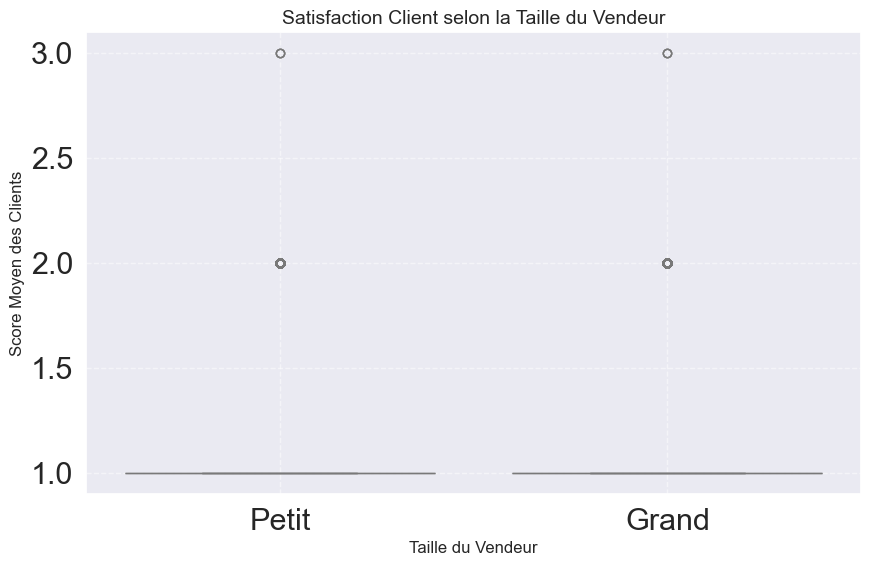

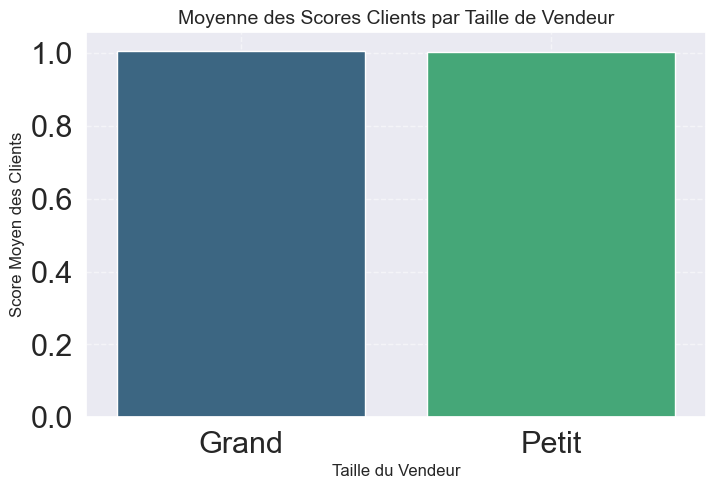

In [23]:
plt.figure(figsize=(10, 6))
sns.boxplot(x="taille_vendeur", y="score", data=achat_vendeur, palette="coolwarm")

plt.title("Satisfaction Client selon la Taille du Vendeur", fontsize=14)
plt.xlabel("Taille du Vendeur", fontsize=12)
plt.ylabel("Score Moyen des Clients", fontsize=12)

plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

df_satisfaction = achat_vendeur.groupby("taille_vendeur")["score"].mean().reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(x="taille_vendeur", y="score", data=df_satisfaction, palette="viridis")

plt.title("Moyenne des Scores Clients par Taille de Vendeur", fontsize=14)
plt.xlabel("Taille du Vendeur", fontsize=12)
plt.ylabel("Score Moyen des Clients", fontsize=12)

plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

#### 5 - Les gros vendeur sont-ils bien noté  ? 

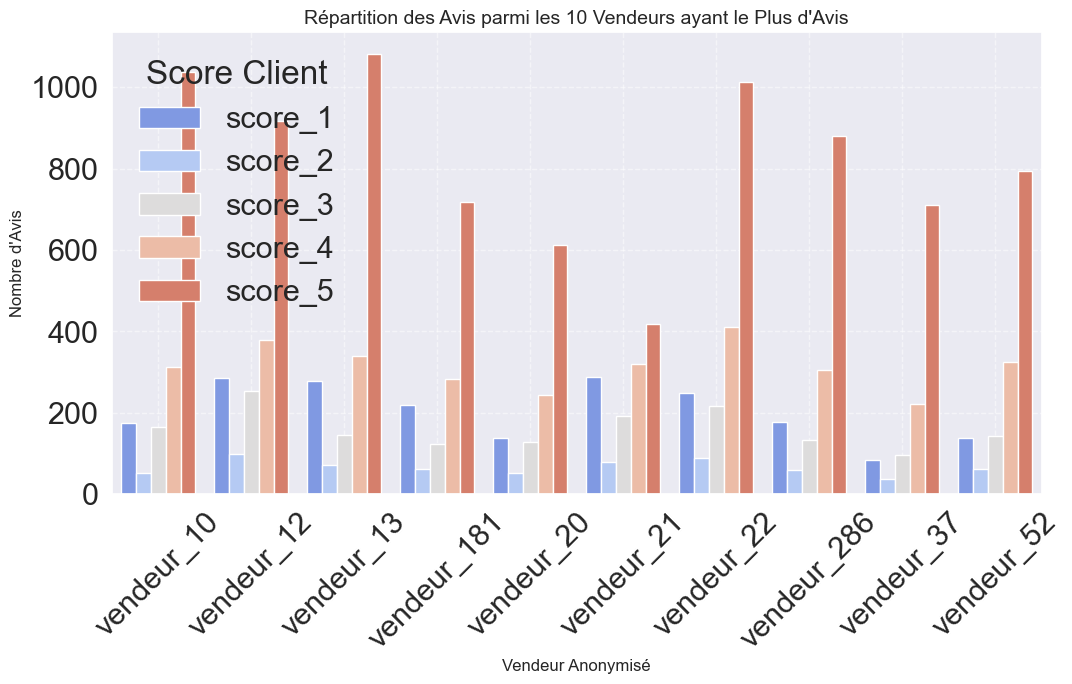

In [24]:
df_avis_vendeur = achat_vendeur.groupby("seller_id_anon")[["score_1", "score_2", "score_3", "score_4", "score_5"]].sum()

top_vendeurs = df_avis_vendeur.sum(axis=1).nlargest(10).index
df_avis_top = achat_vendeur[achat_vendeur["seller_id_anon"].isin(top_vendeurs)]

df_avis_top = df_avis_top.groupby("seller_id_anon")[["score_1", "score_2", "score_3", "score_4", "score_5"]].sum().reset_index()

df_avis_melted = df_avis_top.melt(id_vars="seller_id_anon", var_name="score", value_name="nombre_avis")

plt.figure(figsize=(12, 6))
sns.barplot(x="seller_id_anon", y="nombre_avis", hue="score", data=df_avis_melted, palette="coolwarm")

plt.title("Répartition des Avis parmi les 10 Vendeurs ayant le Plus d'Avis", fontsize=14)
plt.xlabel("Vendeur Anonymisé", fontsize=12)
plt.ylabel("Nombre d'Avis", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Score Client")

plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

#### 6 - Les gros vendeur arrivent-ils a ventre plus de produit cher ? 

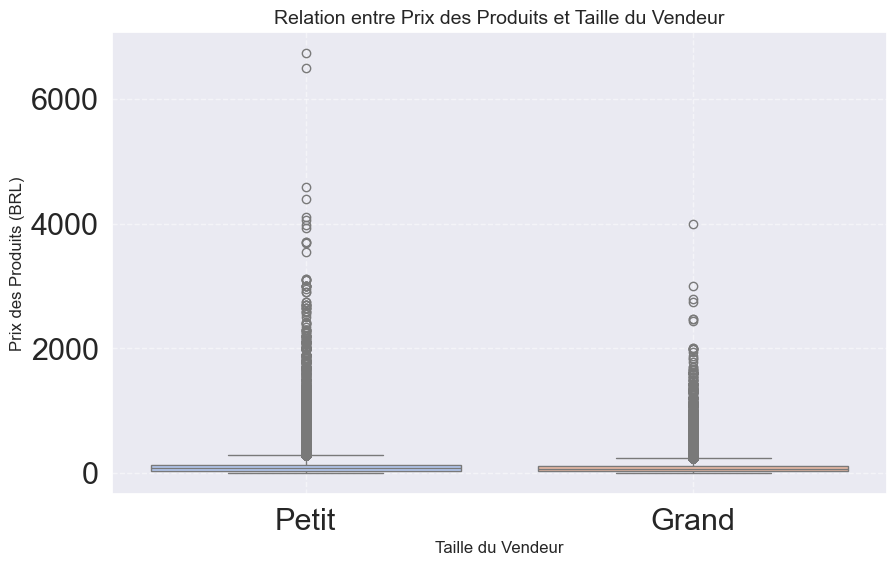

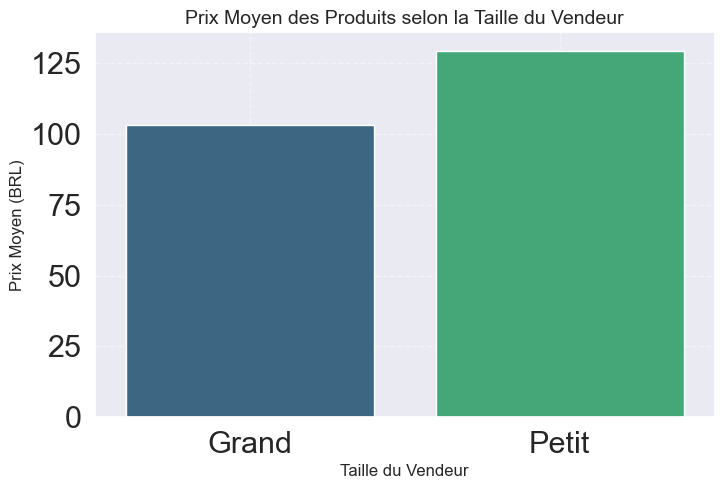

In [25]:
plt.figure(figsize=(10, 6))
sns.boxplot(x="taille_vendeur", y="price", data=achat_vendeur, palette="coolwarm")

plt.title("Relation entre Prix des Produits et Taille du Vendeur", fontsize=14)
plt.xlabel("Taille du Vendeur", fontsize=12)
plt.ylabel("Prix des Produits (BRL)", fontsize=12)

plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

df_prix_moyen = achat_vendeur.groupby("taille_vendeur")["price"].mean().reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(x="taille_vendeur", y="price", data=df_prix_moyen, palette="viridis")

plt.title("Prix Moyen des Produits selon la Taille du Vendeur", fontsize=14)
plt.xlabel("Taille du Vendeur", fontsize=12)
plt.ylabel("Prix Moyen (BRL)", fontsize=12)

plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

#### 7 - Différence des parts du marché entre petit et gros vendeur

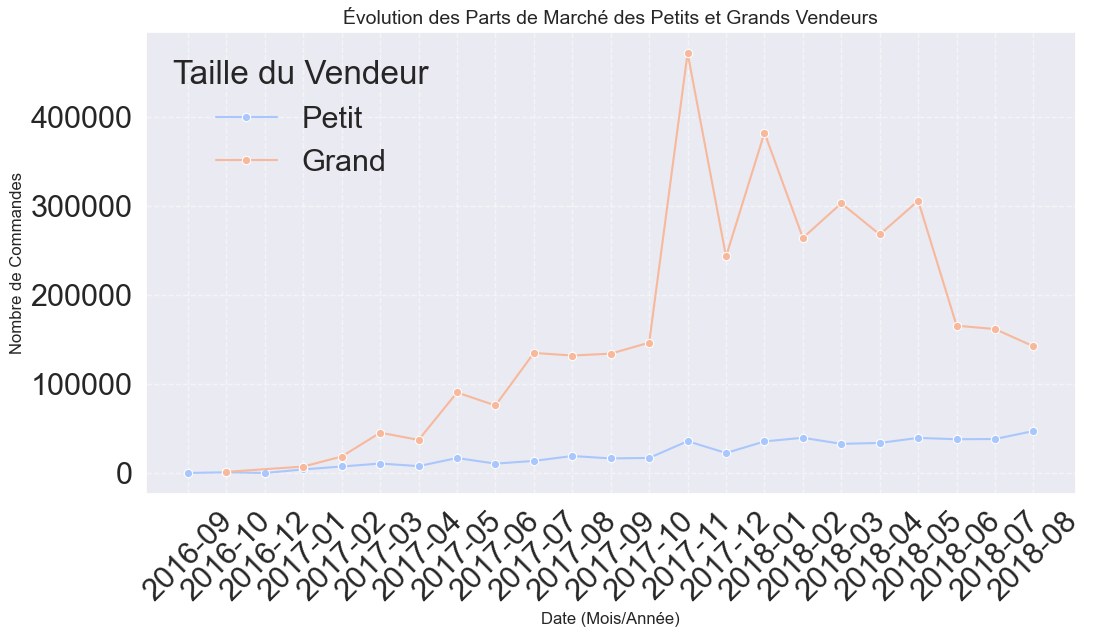

In [26]:
df_parts_marche = achat_vendeur.groupby(["annee_mois", "taille_vendeur"])["evolution_part_marche"].sum().reset_index()

df_parts_marche["annee_mois"] = df_parts_marche["annee_mois"].astype(str)  

plt.figure(figsize=(12, 6))
sns.lineplot(x="annee_mois", y="evolution_part_marche", hue="taille_vendeur", data=df_parts_marche, marker="o", palette="coolwarm")

plt.title("Évolution des Parts de Marché des Petits et Grands Vendeurs", fontsize=14)
plt.xlabel("Date (Mois/Année)", fontsize=12)
plt.ylabel("Nombre de Commandes", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Taille du Vendeur")

plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

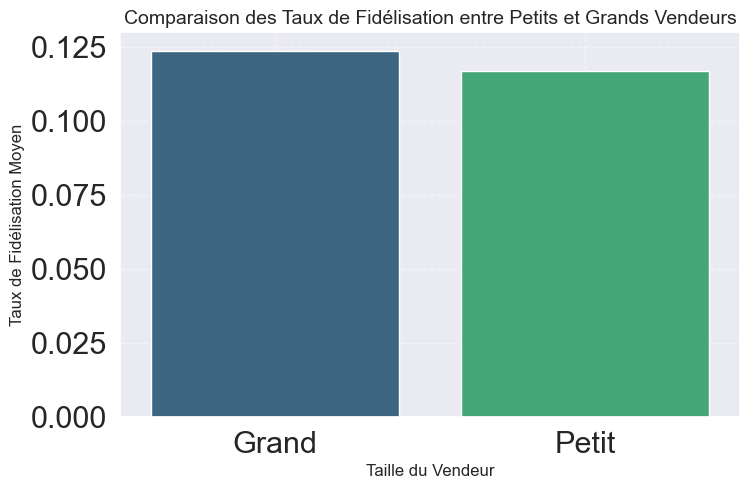

In [27]:
df_fidelisation = achat_vendeur.groupby("taille_vendeur")["taux_fidelisation_vendeur"].mean().reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(x="taille_vendeur", y="taux_fidelisation_vendeur", data=df_fidelisation, palette="viridis")

plt.title("Comparaison des Taux de Fidélisation entre Petits et Grands Vendeurs", fontsize=14)
plt.xlabel("Taille du Vendeur", fontsize=12)
plt.ylabel("Taux de Fidélisation Moyen", fontsize=12)

plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

#### 8 - Différence entre l'impact des promotion sur les petits et les gros vendeurs

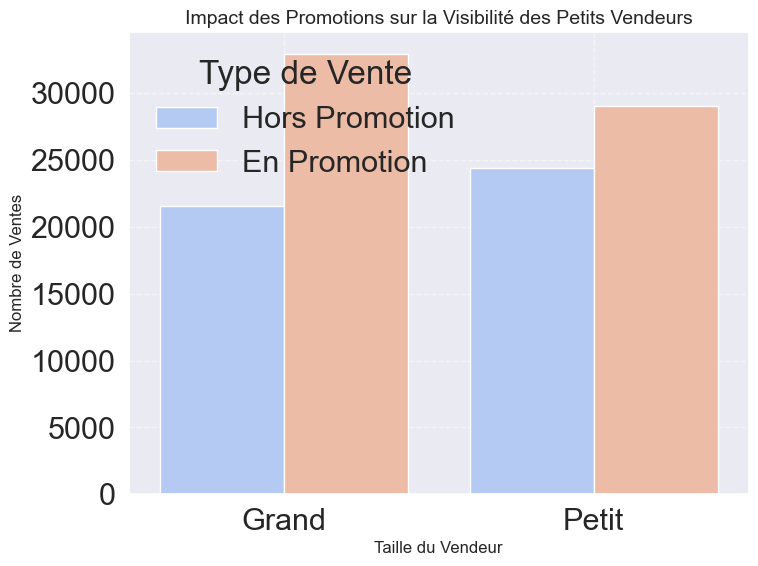

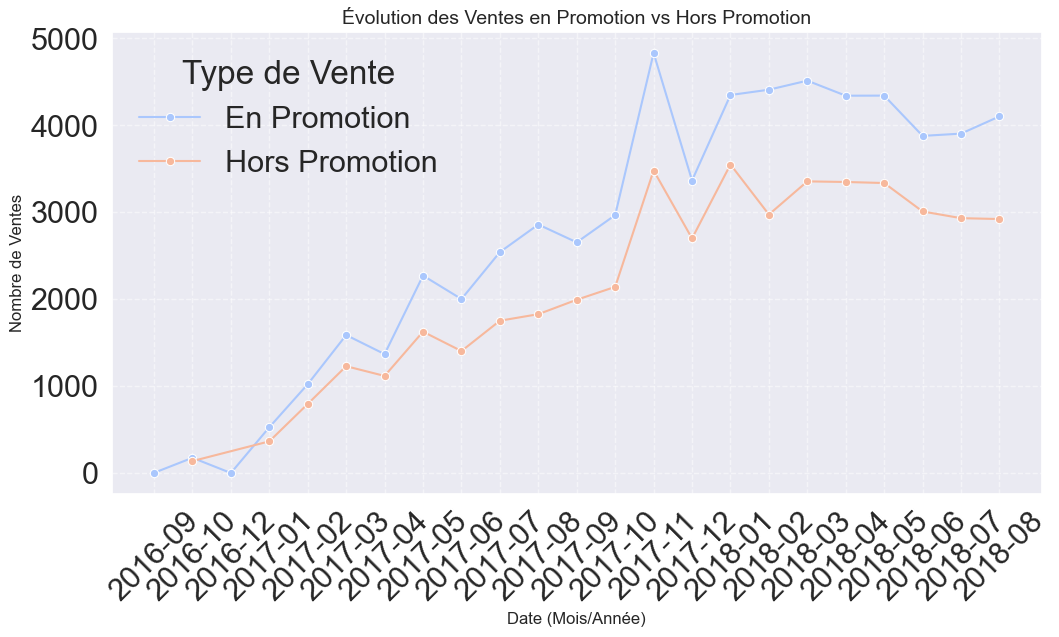

In [28]:
achat_vendeur["prix_moyen_categorie"] = achat_vendeur.groupby("category_name")["price"].transform("mean")
achat_vendeur["promotion"] = achat_vendeur["price"] < (achat_vendeur["prix_moyen_categorie"] * 0.8)  # Produit en promo si prix < 80% du prix moyen

df_promo_taille = achat_vendeur.groupby(["taille_vendeur", "promotion"])["order_id"].count().reset_index()
df_promo_taille["promotion"] = df_promo_taille["promotion"].map({True: "En Promotion", False: "Hors Promotion"})


plt.figure(figsize=(8, 6))
sns.barplot(x="taille_vendeur", y="order_id", hue="promotion", data=df_promo_taille, palette="coolwarm")

plt.title("Impact des Promotions sur la Visibilité des Petits Vendeurs", fontsize=14)
plt.xlabel("Taille du Vendeur", fontsize=12)
plt.ylabel("Nombre de Ventes", fontsize=12)
plt.legend(title="Type de Vente")

plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

df_promo_time = achat_vendeur.groupby(["annee_mois", "promotion"])["order_id"].count().reset_index()
df_promo_time["promotion"] = df_promo_time["promotion"].map({True: "En Promotion", False: "Hors Promotion"})
df_promo_time["annee_mois"] = df_promo_time["annee_mois"].astype(str)

plt.figure(figsize=(12, 6))
sns.lineplot(x="annee_mois", y="order_id", hue="promotion", data=df_promo_time, marker="o", palette="coolwarm")

plt.title("Évolution des Ventes en Promotion vs Hors Promotion", fontsize=14)
plt.xlabel("Date (Mois/Année)", fontsize=12)
plt.ylabel("Nombre de Ventes", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Type de Vente")

plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

### 3/ Analyse de la Fidélité des Clients 

#### Préparation des données 

In [29]:
achat_fidelite = achat.copy()

achat_fidelite["nb_achats_client"] = achat_fidelite.groupby("customer_unique_id")["order_id"].transform("count")

achat_fidelite["categorie_preferee_client"] = achat_fidelite.groupby("customer_unique_id")["category_name"].transform(lambda x: x.mode()[0] if not x.mode().empty else None)

achat_fidelite["client_fidele"] = achat_fidelite["nb_achats_client"] > 1

achat_fidelite["panier_moyen_client"] = achat_fidelite.groupby("customer_unique_id")["price"].transform("mean")

achat_fidelite["valeur_client"] = achat_fidelite.groupby("customer_unique_id")["price"].transform("sum")

achat_fidelite["ancien_client"] = achat_fidelite.groupby("customer_unique_id")["annee_mois"].transform("min") < achat_fidelite["annee_mois"]

achat_fidelite["impact_promo_fidelisation"] = achat_fidelite.groupby("customer_unique_id")["periode_soldes"].transform("mean")

achat_fidelite["satisfaction_client_fidele"] = achat_fidelite.groupby("customer_unique_id")["score"].transform("mean")

achat_fidelite.info()

<class 'pandas.core.frame.DataFrame'>
Index: 107975 entries, 0 to 112649
Data columns (total 67 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   order_id                    107975 non-null  object        
 1   order_item_id               107975 non-null  int64         
 2   product_id                  107975 non-null  object        
 3   seller_id                   107975 non-null  object        
 4   price                       107975 non-null  float64       
 5   freight_value               107975 non-null  float64       
 6   shipping_limit              107975 non-null  datetime64[us]
 7   limit                       107975 non-null  float64       
 8   name_lenght                 106489 non-null  float64       
 9   description_lenght          106489 non-null  float64       
 10  photos_qty                  106489 non-null  float64       
 11  weight_g                    107975 non-null 

#### 1 - Classement des types de clients pas nombre d'achat

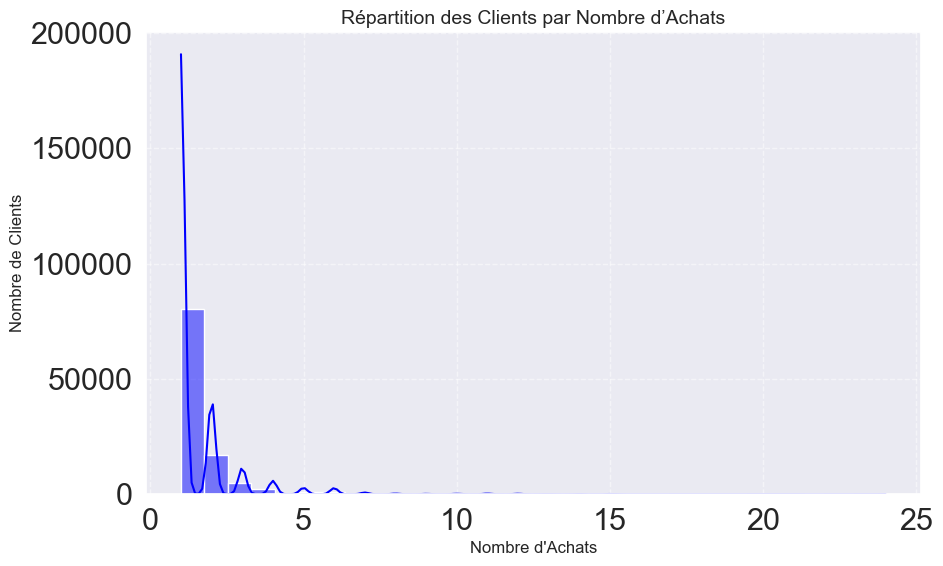

In [30]:
plt.figure(figsize=(10, 6))
sns.histplot(achat_fidelite["nb_achats_client"], bins=30, kde=True, color="blue")

plt.title("Répartition des Clients par Nombre d’Achats", fontsize=14)
plt.xlabel("Nombre d'Achats", fontsize=12)
plt.ylabel("Nombre de Clients", fontsize=12)

plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

#### 2 - Qu'elles sont les catégories les plus apprécié par les clients fidèle ? 

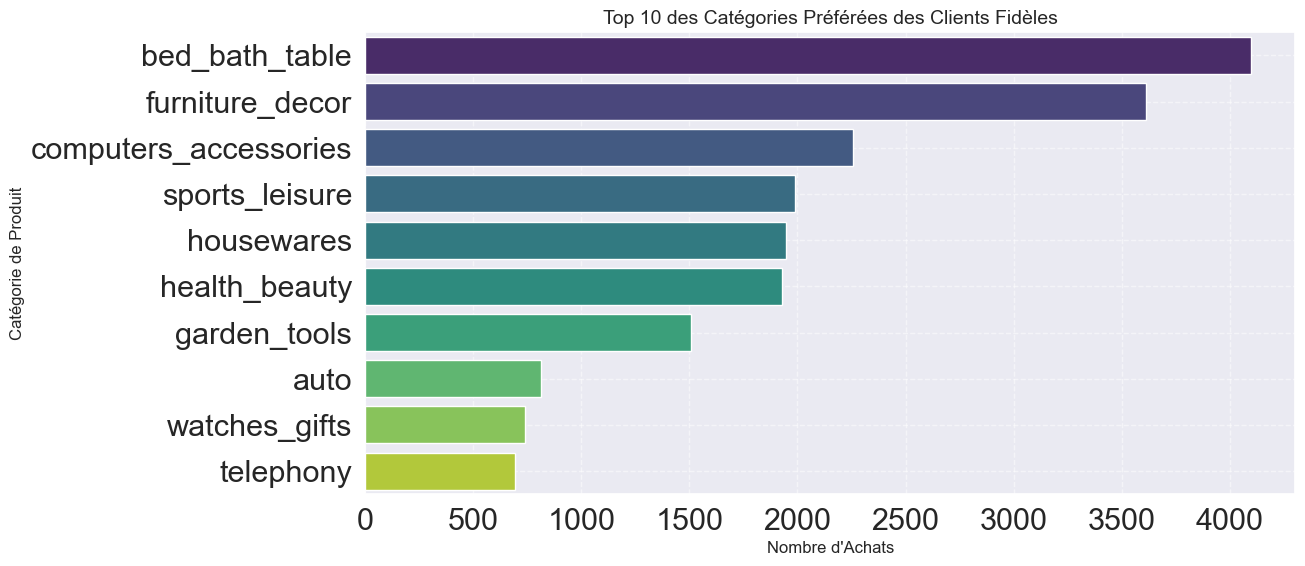

In [31]:
df_clients_fideles = achat_fidelite[achat_fidelite["client_fidele"] == True]

top_categories_fideles = df_clients_fideles["categorie_preferee_client"].value_counts().nlargest(10).reset_index()
top_categories_fideles.columns = ["category_name", "nombre_achats"]

plt.figure(figsize=(12, 6))
sns.barplot(x="nombre_achats", y="category_name", data=top_categories_fideles, palette="viridis")

plt.title("Top 10 des Catégories Préférées des Clients Fidèles", fontsize=14)
plt.xlabel("Nombre d'Achats", fontsize=12)
plt.ylabel("Catégorie de Produit", fontsize=12)

plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

#### 3 - Es ce que la plateforme a su fidéliser des clients au file du temps ? 

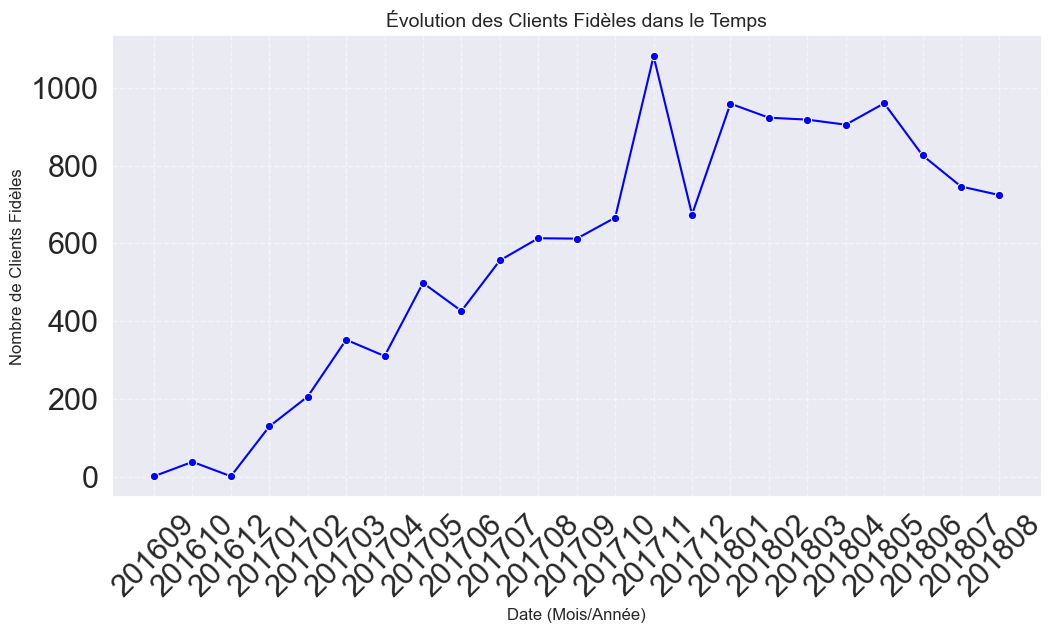

In [32]:
df_fideles_temps = achat_fidelite[achat_fidelite["client_fidele"] == True].groupby("annee_mois")["customer_unique_id"].nunique().reset_index()
df_fideles_temps.columns = ["annee_mois", "nombre_clients_fideles"]

df_fideles_temps["annee_mois"] = df_fideles_temps["annee_mois"].astype(str)

plt.figure(figsize=(12, 6))
sns.lineplot(x="annee_mois", y="nombre_clients_fideles", data=df_fideles_temps, marker="o", color="blue")

plt.title("Évolution des Clients Fidèles dans le Temps", fontsize=14)
plt.xlabel("Date (Mois/Année)", fontsize=12)
plt.ylabel("Nombre de Clients Fidèles", fontsize=12)
plt.xticks(rotation=45)

plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

#### 4 - Les clients fidèle consomme t'ils plus que les clients non fidèle ? 

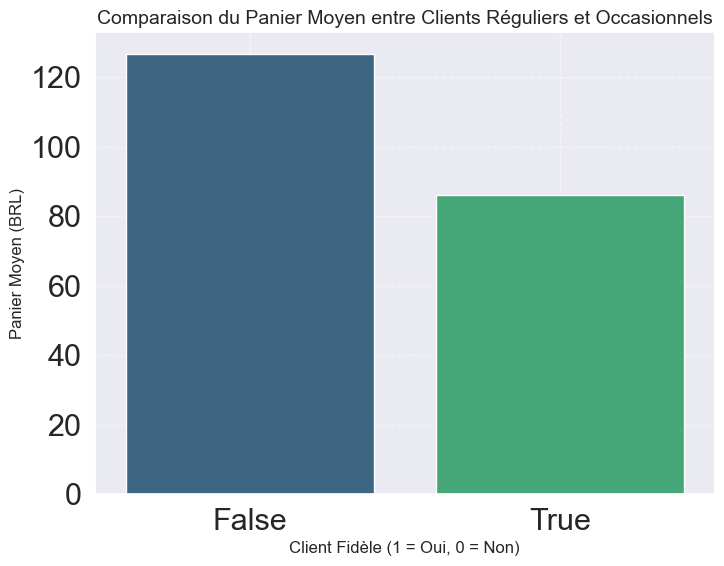

In [33]:
df_panier_fideles = achat_fidelite.groupby("client_fidele")["panier_moyen_client"].mean().reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(x="client_fidele", y="panier_moyen_client", data=df_panier_fideles, palette="viridis")

plt.title("Comparaison du Panier Moyen entre Clients Réguliers et Occasionnels", fontsize=14)
plt.xlabel("Client Fidèle (1 = Oui, 0 = Non)", fontsize=12)
plt.ylabel("Panier Moyen (BRL)", fontsize=12)

plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

#### 5 - Qu'elle est la répartition de nos client en fonction du prix qu'ils payent ? 

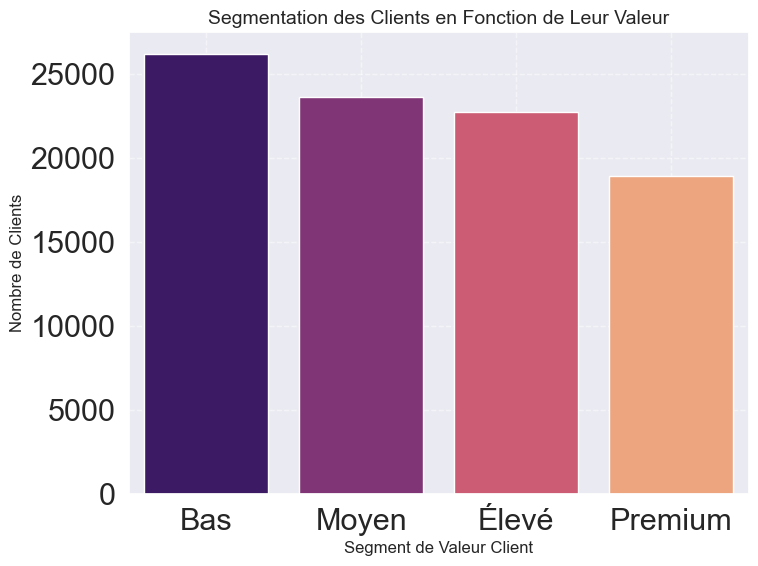

In [34]:
achat_fidelite["segment_valeur_client"] = pd.qcut(achat_fidelite["valeur_client"], q=4, labels=["Bas", "Moyen", "Élevé", "Premium"])

df_segmentation = achat_fidelite.groupby("segment_valeur_client")["customer_unique_id"].nunique().reset_index()
df_segmentation.columns = ["Segment", "Nombre de Clients"]

plt.figure(figsize=(8, 6))
sns.barplot(x="Segment", y="Nombre de Clients", data=df_segmentation, palette="magma", order=["Bas", "Moyen", "Élevé", "Premium"])

plt.title("Segmentation des Clients en Fonction de Leur Valeur", fontsize=14)
plt.xlabel("Segment de Valeur Client", fontsize=12)
plt.ylabel("Nombre de Clients", fontsize=12)

plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

#### 6 - Es ce que les clients fidèle représente une par significative de notre clientèle ? 

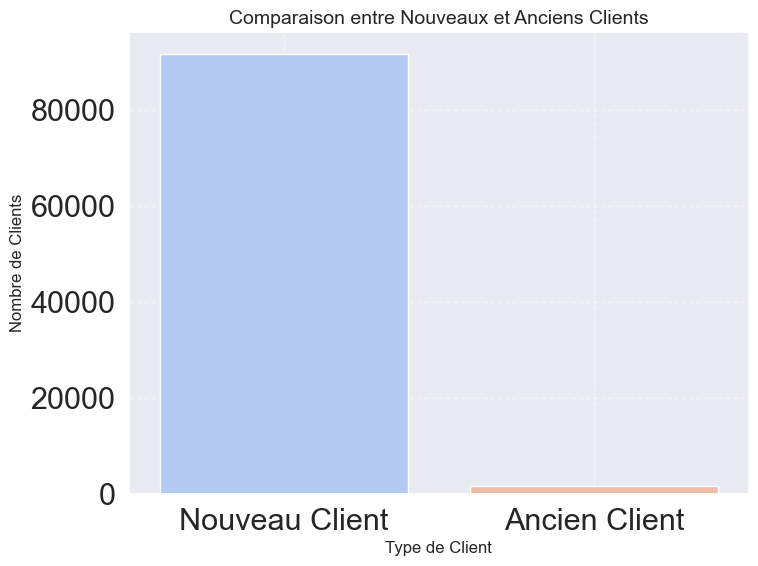

In [35]:
df_clients_nouveaux = achat_fidelite.groupby("ancien_client")["customer_unique_id"].nunique().reset_index()
df_clients_nouveaux.columns = ["ancien_client", "nombre_clients"]
df_clients_nouveaux["ancien_client"] = df_clients_nouveaux["ancien_client"].map({True: "Ancien Client", False: "Nouveau Client"})

plt.figure(figsize=(8, 6))
sns.barplot(x="ancien_client", y="nombre_clients", data=df_clients_nouveaux, palette="coolwarm")

plt.title("Comparaison entre Nouveaux et Anciens Clients", fontsize=14)
plt.xlabel("Type de Client", fontsize=12)
plt.ylabel("Nombre de Clients", fontsize=12)

plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

#### 7 - Qu'elle est l'impact des promotions sur ces deux segments clients ? 

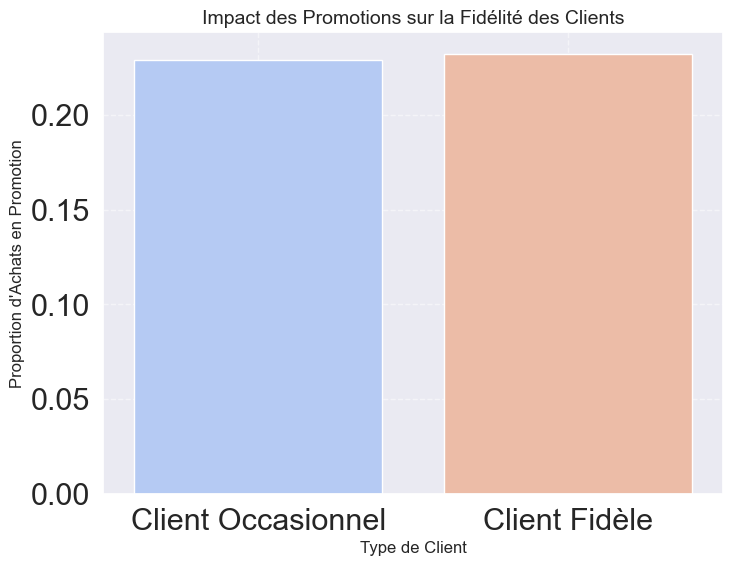

In [36]:
df_promo_fidelite = achat_fidelite.groupby("client_fidele")["impact_promo_fidelisation"].mean().reset_index()
df_promo_fidelite["client_fidele"] = df_promo_fidelite["client_fidele"].map({True: "Client Fidèle", False: "Client Occasionnel"})

plt.figure(figsize=(8, 6))
sns.barplot(x="client_fidele", y="impact_promo_fidelisation", data=df_promo_fidelite, palette="coolwarm")

plt.title("Impact des Promotions sur la Fidélité des Clients", fontsize=14)
plt.xlabel("Type de Client", fontsize=12)
plt.ylabel("Proportion d'Achats en Promotion", fontsize=12)

plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

#### 8 -  Es ce que les clients fidèle sont plus satisfait que les client non fidèle ? 

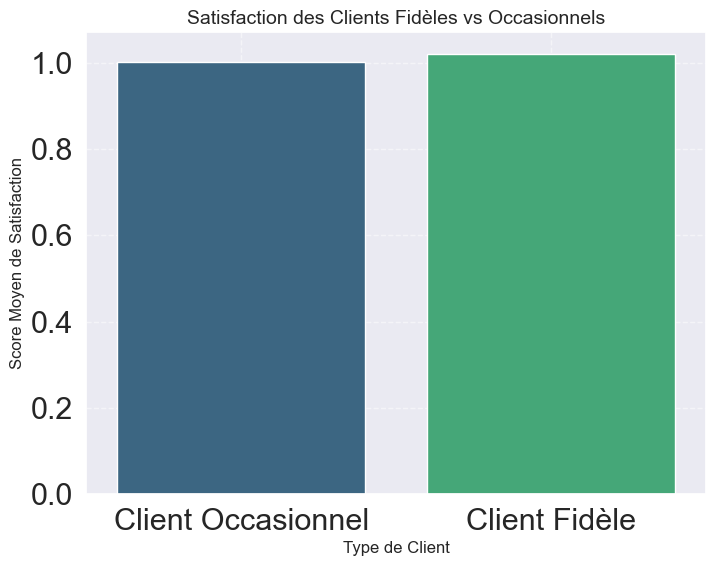

In [37]:
df_satisfaction_fidelite = achat_fidelite.groupby("client_fidele")["satisfaction_client_fidele"].mean().reset_index()
df_satisfaction_fidelite["client_fidele"] = df_satisfaction_fidelite["client_fidele"].map({True: "Client Fidèle", False: "Client Occasionnel"})

plt.figure(figsize=(8, 6))
sns.barplot(x="client_fidele", y="satisfaction_client_fidele", data=df_satisfaction_fidelite, palette="viridis")

plt.title("Satisfaction des Clients Fidèles vs Occasionnels", fontsize=14)
plt.xlabel("Type de Client", fontsize=12)
plt.ylabel("Score Moyen de Satisfaction", fontsize=12)

plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

#### 9 - Peut on définir des catégories qui plaise au client qui dépense le plus ? 

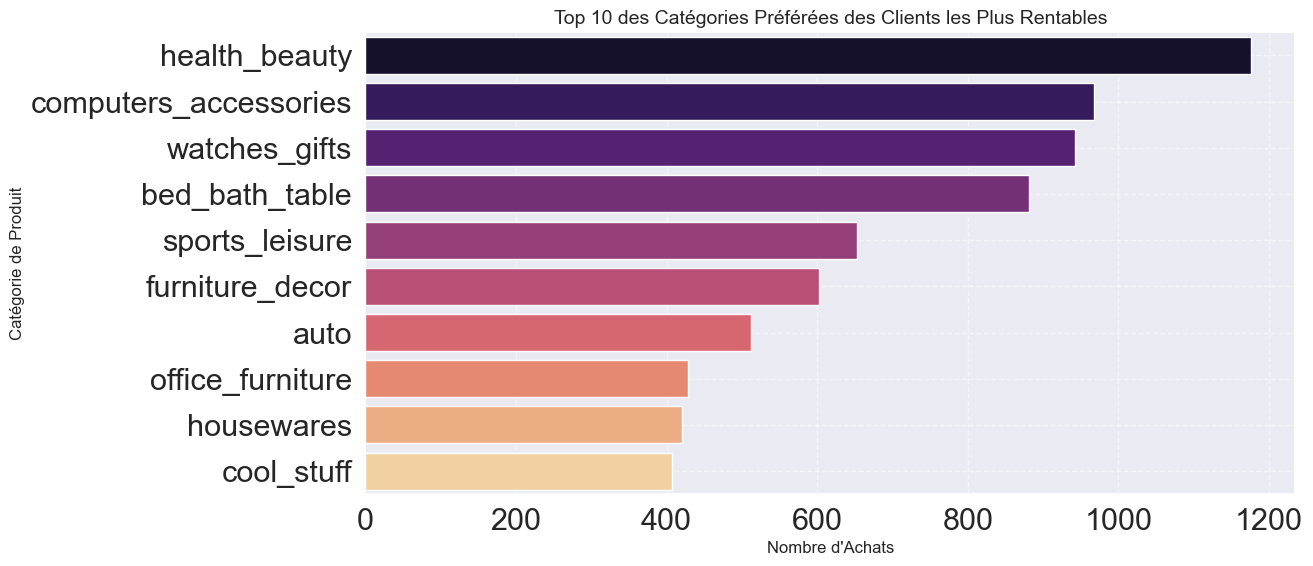

In [38]:
seuil_rentabilite = achat_fidelite["valeur_client"].quantile(0.90)  # Seuil des 10% clients les plus rentables
df_clients_rentables = achat_fidelite[achat_fidelite["valeur_client"] >= seuil_rentabilite]

top_categories_rentables = df_clients_rentables["categorie_preferee_client"].value_counts().nlargest(10).reset_index()
top_categories_rentables.columns = ["category_name", "nombre_achats"]

plt.figure(figsize=(12, 6))
sns.barplot(x="nombre_achats", y="category_name", data=top_categories_rentables, palette="magma")

plt.title("Top 10 des Catégories Préférées des Clients les Plus Rentables", fontsize=14)
plt.xlabel("Nombre d'Achats", fontsize=12)
plt.ylabel("Catégorie de Produit", fontsize=12)

plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

#### 10 - Peut on définir un rapport entre l valeur d'un client, sa fidélisation et l'impact des promotion ? 

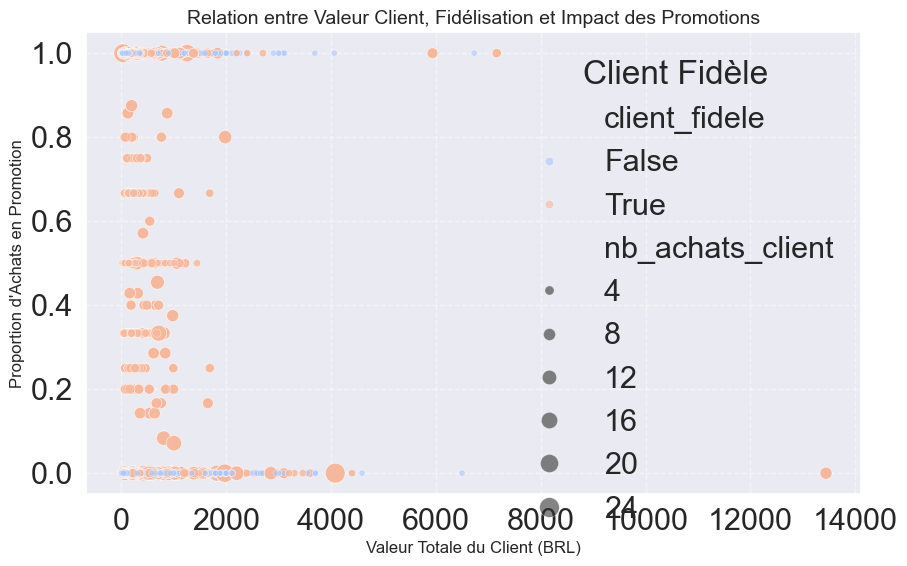

In [39]:
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(
    x=achat_fidelite["valeur_client"],
    y=achat_fidelite["impact_promo_fidelisation"],
    size=achat_fidelite["nb_achats_client"],
    hue=achat_fidelite["client_fidele"],
    palette="coolwarm",
    alpha=0.6,
    sizes=(20, 200)  
)

plt.title("Relation entre Valeur Client, Fidélisation et Impact des Promotions", fontsize=14)
plt.xlabel("Valeur Totale du Client (BRL)", fontsize=12)
plt.ylabel("Proportion d'Achats en Promotion", fontsize=12)

plt.legend(title="Client Fidèle")

plt.grid(True, linestyle="--", alpha=0.5)
plt.show()